# Исследовательский анализ рынка заведений общественного питания Москвы

## Цель и задачи  

**Цель:** Провести исследовательский анализ рынка заведений обзественного питания Москвы с целью определения наиболее подходящего места для открытия заведения.   

**Задачи:**
1. Загрузить данные и познакомиться с их содержимым.
2. Провести предобработку данных.
3. Провести исследовательский анализ данных:
    - изучить категории заведений;
    - исследовать распределение количества заведений по административным районам Москвы, а также отдельно распределение заведений каждой категории в Центральном административном округе Москвы;
    - изучить соотношение сетевых и несетевых заведений в целом по всем данным и в разрезе категорий заведения;
    - исследовать количество посадочных мест в заведениях, привести для каждой категории заведений наиболее типичное для него количество посадочных мест;
    - исследовать рейтинг заведений;
    - изучить, с какими данными показывают самую сильную корреляцию рейтинги заведений;
    - опрелелить топ-15 популярных сетей Москвы, посчитать для них значения среднего рейтига;
    - изучить вариацию среднего чека заведения (столбец middle_avg_bill) в зависимости от района Москвы. Проанализировать цены в центральном административном округе и других. Определить как удалённость от центра влияет на цены в заведениях.
4. Сформулировать выводы и рекомендации по проведённому анализу.


## Данные

Данные состоят из двух датасетов:

- [`datasets/rest_info.csv`](https://code.s3.yandex.net/datasets/rest_info.csv) — информация о заведениях общественного питания;
- [`clients_information.csv`](https://code.s3.yandex.net/datasets/price_info.csv) —  персональная информация клиентов.

***Датасеты ссоставлены на основе данных сервисов Яндекс Карты и Яндекс Бизнес на лето 2022 года*** 

### Описание датасета `rest_info`

- `name` — название заведения;
- `address` — адрес заведения;
- `district` — административный район, в котором находится заведение, например Центральный административный округ;
- `category` — категория заведения, например «кафе», «пиццерия» или «кофейня»;
- `hours` — информация о днях и часах работы;
- `rating` — рейтинг заведения по оценкам пользователей в Яндекс Картах (высшая оценка — 5.0);
- `chain` — число, выраженное 0 или 1, которое показывает, является ли заведение сетевым (для маленьких сетей могут встречаться ошибки):
    0 — заведение не является сетевым;
    1 — заведение является сетевым.
- `seats` — количество посадочных мест.

### Описание датасета `rest_price`

- `price` — категория цен в заведении, например «средние», «ниже среднего», «выше среднего» и так далее;
- `avg_bill` — строка, которая хранит среднюю стоимость заказа в виде диапазона, например:
    «Средний счёт: 1000–1500 ₽»;
    «Цена чашки капучино: 130–220 ₽»;
    «Цена бокала пива: 400–600 ₽».
    и так далее;
- `middle_avg_bill` — число с оценкой среднего чека, которое указано только для значений из столбца avg_bill, начинающихся с подстроки «Средний счёт»:
    Если в строке указан ценовой диапазон из двух значений, в столбец войдёт медиана этих двух значений.
    Если в строке указано одно число — цена без диапазона, то в столбец войдёт это число.
    Если значения нет или оно не начинается с подстроки «Средний счёт», то в столбец ничего не войдёт.
- `middle_coffee_cup` — число с оценкой одной чашки капучино, которое указано только для значений из столбца avg_bill, начинающихся с подстроки «Цена одной чашки капучино»:
    Если в строке указан ценовой диапазон из двух значений, в столбец войдёт медиана этих двух значений.
    Если в строке указано одно число — цена без диапазона, то в столбец войдёт это число.
    Если значения нет или оно не начинается с подстроки «Цена одной чашки капучино», то в столбец ничего не войдёт.


## Структура проекта

- Загрузка данных и знакомство с ними.
- Предобработка данных.
- Исследовательский анализ данных.
- Итоговые выводы.

---


##  Загрузка данных и знакомство с ними

Начнём с загрузки библиотек и датасетов `rest_info` и `rest_price`. Будем использовать pandas и библиотеки визуализации данных matplotlib и seaborn, а также phik_matrix для построения матрицы корреляции. Данные датасетов сохраним в двух переменных: `df_info` и `df_price`.

In [1]:
!pip install phik -U

  Using cached phik-0.12.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (686 kB)


In [2]:
# Импортируем библиотеки
import pandas as pd

# Загружаем библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем библиотеку для расчёта коэффициента корреляции phi_k
import phik

# датасеты размещены локально, на Яндекс.диске и на Google Диске
# для исключения ошибок чтения данных обеспечим возможность чтения данных с облачного хранилища
from io import BytesIO # для чтение данных из Google Диска
import requests # отправим заропс в Google Диск

In [3]:
try:
    # Попытка прочитать локальный файл rest_info
    df_info = pd.read_csv("/Users/veragushchina/Downloads/rest_info.csv", sep=',', skiprows=0, on_bad_lines='error')
except Exception:
    try:
        # Не получилось — скачать из интернета по url
        df_info = pd.read_csv('https://code.s3.yandex.net/datasets/rest_info.csv')
    except Exception:
        # И если и это не удалось — получить из Google Диска
        r = requests.get('https://docs.google.com/spreadsheets/d/1fVQB0ul2ZkIpzU3QCxJNgFSyv43ObyFJhxoD-5V8h_o/export?format=csv&id=1fVQB0ul2ZkIpzU3QCxJNgFSyv43ObyFJhxoD-5V8h_o&gid=1792005382')
        data = r.content
        df_info = pd.read_csv(BytesIO(data), sep=',', skiprows=0, on_bad_lines='error')

In [4]:
try:
    # Попытка прочитать локальный файл price_info
    df_price =  pd.read_csv("/Users/veragushchina/Downloads/rest_price.csv", sep=',', skiprows=0)
except Exception:
    try:
        # Не получилось — скачать из интернета по url
        df_price = pd.read_csv('https://code.s3.yandex.net/datasets/price_info.csv')
    except Exception:
        # И если и это не удалось — получить из Google Диска
        r = requests.get('https://docs.google.com/spreadsheets/d/1atMLdLexJikKJg-20l70n3XyMUuV2xAr5Arptr1X62E/export?format=csv&id=1atMLdLexJikKJg-20l70n3XyMUuV2xAr5Arptr1X62E&gid=1317756756')
        data = r.content
        df_price = pd.read_csv(BytesIO(data), sep=',', skiprows=0)

In [5]:
# Посмотрим размер датафрейма df_info
df_info.shape

(8406, 9)

In [6]:
# Выведем для обзора несколько строк датафрейма df_info
display(df_info.head())

,id,name,category,address,district,hours,rating,chain,seats
0,0c3e3439a8c64ea5bf6ecd6ca6ae19f0,WoWфли,кафе,"Москва, улица Дыбенко, 7/1",Северный административный округ,"ежедневно, 10:00–22:00",5.0,0,NaN
1,045780ada3474c57a2112e505d74b633,Четыре комнаты,ресторан,"Москва, улица Дыбенко, 36, корп. 1",Северный административный округ,"ежедневно, 10:00–22:00",4.5,0,4.0
2,1070b6b59144425896c65889347fcff6,Хазри,кафе,"Москва, Клязьминская улица, 15",Северный административный округ,"пн-чт 11:00–02:00; пт,сб 11:00–05:00; вс 11:00...",4.6,0,45.0
3,03ac7cd772104f65b58b349dc59f03ee,Dormouse Coffee Shop,кофейня,"Москва, улица Маршала Федоренко, 12",Северный административный округ,"ежедневно, 09:00–22:00",5.0,0,NaN
4,a163aada139c4c7f87b0b1c0b466a50f,Иль Марко,пиццерия,"Москва, Правобережная улица, 1Б",Северный административный округ,"ежедневно, 10:00–22:00",5.0,1,148.0


In [7]:
# Посмотрим информацию о датафрейме df_info с целью ознакомления с типами данных столбцов и предварительного анализа пропусков.
df_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8406 entries, 0 to 8405
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        8406 non-null   object 
 1   name      8406 non-null   object 
 2   category  8406 non-null   object 
 3   address   8406 non-null   object 
 4   district  8406 non-null   object 
 5   hours     7870 non-null   object 
 6   rating    8406 non-null   float64
 7   chain     8406 non-null   int64  
 8   seats     4795 non-null   float64
dtypes: float64(2), int64(1), object(6)
memory usage: 591.2+ KB


Датасет df_info содержит 8406 строк и 9 столбцов. Названия столбцов соответствуют описанию данных и их написание удобно для дальнейшего анализа. Типы данных, за исключением стоблбца 'seats' (так как количество стульев не может быть дробным, корректнее изменить тип данных на interger), указаны корректно.  Помимо столбца с названием заведения присутствует столбец с уникальными идентификатором, наличие которого не было обозначено в описании данных. Больше всего пропусков содержится в столбцах, содержащих информацию о часах работы и количестве посадочных мест в заведении. 

In [8]:
# Посмотрим размер датафрейма df_price
df_price.shape

(4058, 5)

In [9]:
# Выведем для обзора несколько строк датафрейма df_price
display(df_price.head())

,id,price,avg_bill,middle_avg_bill,middle_coffee_cup
0,045780ada3474c57a2112e505d74b633,выше среднего,Средний счёт:1500–1600 ₽,1550.0,NaN
1,1070b6b59144425896c65889347fcff6,средние,Средний счёт:от 1000 ₽,1000.0,NaN
2,03ac7cd772104f65b58b349dc59f03ee,NaN,Цена чашки капучино:155–185 ₽,NaN,170.0
3,a163aada139c4c7f87b0b1c0b466a50f,средние,Средний счёт:400–600 ₽,500.0,NaN
4,8a343546b24e4a499ad96eb7d0797a8a,средние,NaN,NaN,NaN


In [10]:
# Посмотрим информацию о датафрейме df_price с целью ознакомления с типами данных столбцов и предварительного анализа пропусков.
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4058 entries, 0 to 4057
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 4058 non-null   object 
 1   price              3315 non-null   object 
 2   avg_bill           3816 non-null   object 
 3   middle_avg_bill    3149 non-null   float64
 4   middle_coffee_cup  535 non-null    float64
dtypes: float64(2), object(3)
memory usage: 158.6+ KB


Датасет df_price содержит 4058 строк и 5 столбцов. Названия столбцов соответствуют описанию данных и их написание удобно для дальнейшего анализа. Типы данных указаны корректно.  Помимо столбца с названием заведения присутствует столбец с уникальными идентификатором, наличие которого не было обозначено в описании данных. Учитывая, что строк в датасете df_price меньше, чем в df_info, вероятно, значение id обозначает название заведения с привязкой к адресу. Больше всего пропусков содержится в столбцах, содержащих информацию об оценке одной чашки капучино, оценке среднего чека, категории цен в заведении и средней стоимости заказа.
______________

##  Предобработка данных

### Оптимизируем типы данных

Проведем форматирование данных в целочисленный тип. Будем использовать функцию astype с аргументом 'Int64', что позволит нам сохранить пропуски для дальнейшей работы с ними и не вызывать ошибку.

In [11]:
 # Оптимизируем целочисленный тип данных в датафрейме df_info
df_info['seats'] = df_info['seats'].astype('Int64')

In [12]:
# Проверим типы данных в датафрейме df_info с помощью атрибута dtypes
df_info.dtypes

id           object
name         object
category     object
address      object
district     object
hours        object
rating      float64
chain         int64
seats         Int64
dtype: object

Типы данных успешно изменены.
___________

### Обработаем пропуски в данных

Посчитаем количество пропусков в датафреймах в абсолютных и относительных значениях.

In [13]:
# Исследуем датафрейм df_info
missing_percentage_df_info = round(df_info.isna().sum() / len(df_info) * 100,2) 
missing_df_info = pd.DataFrame({
    'Количество пропусков': df_info.isna().sum(),
    'Процент пропусков (%)': missing_percentage_df_info
})
print("\nАнализ пропущенных значений в датафрейме df_info :")
display(missing_df_info)


Анализ пропущенных значений в датафрейме df_info :


,Количество пропусков,Процент пропусков (%)
id,0,0.00
name,0,0.00
category,0,0.00
address,0,0.00
district,0,0.00
hours,536,6.38
rating,0,0.00
chain,0,0.00
seats,3611,42.96


Данные содержат пропуски в столбцах 'hours' (6,4%) и 'seats' (43%). Одной из причин возникновения пропусков может явиться необязательность заполнения указанных параметров в источниках сбора данных для датасета. Восполнить эти значения не представляется возможным, так как это индивидуальные параметры заведения. Удаление пустых значений приведет к потере данных и искажению результата анализа, в связи с чем оставим пропуски без обработки.

In [14]:
# Исследуем датафрейм df_price
missing_percentage_df_price = round(df_price.isna().sum() / len(df_price) * 100,2) 
missing_df_price = pd.DataFrame({
    'Количество пропусков': df_price.isna().sum(),
    'Процент пропусков (%)': missing_percentage_df_price
})
print("\nАнализ пропущенных значений в датафрейме df_price :")
display(missing_df_price)


Анализ пропущенных значений в датафрейме df_price :


,Количество пропусков,Процент пропусков (%)
id,0,0.00
price,743,18.31
avg_bill,242,5.96
middle_avg_bill,909,22.40
middle_coffee_cup,3523,86.82


Данные сожержат пропуски практически в каждом столбце. 

Так как датасеты составлены на сонове данных сервисов Яндекс Карты и Яндекс Бизнес (для последнего - информация могла быть добавлена пользователями) или найдена в общедоступных источниках - заполнение полей 'price' и 'avg_bill' в отсутствие утвержденной категоризации и методики могло проводиться пользователями субъективно, или не заполняться вовсе.

Самый большой процент пропусков в столбце 'middle_coffee_cup' (87%) - число с оценкой одной чашки капучино, которое указано только для значений из столбца avg_bill, начинающихся с подстроки «Цена одной чашки капучино». Столбец 'avg_bill' содержит 6% пропусков и хранит информацию о средней стоимости заказа, при этом необходимая для исследования информация уже содержится в столбце 'middle_avg_bill' (число с оценкой среднего чека, которое указано только для значений из столбца 'avg_bill', начинающихся с подстроки «Средний счёт»). Поставленные перед исследованием задачи не предполагают обращение к данным столбцов 'middle_coffee_cup' и 'avg_bill', в связи с чем их можно удалить. 

In [15]:
# Удалим ненужные столбцы
del df_price['avg_bill'], df_price['middle_coffee_cup']

Для дальнейшего анализа нам потребуются столбцы 'price' и 'middle_avg_bill'

In [16]:
# Посмотрим статистические показатели в датафрейме df_price
df_price.describe()

,middle_avg_bill
count,3149.000000
mean,958.053668
std,1009.732845
min,0.000000
25%,375.000000
50%,750.000000
75%,1250.000000
max,35000.000000


Данные содержат большой разброс, о чем свидетельствует большой размах между минимальным (0 р.) и максимальным (35 000 р.) значением, разница между медианным и средним значением. 

Проверим, какое количество строк содержат значение "0" в столбце middle_avg_bill

In [17]:
display(df_price[df_price['middle_avg_bill']==0])

,id,price,middle_avg_bill
1780,502d91289bc5470eabd77fd77cc79821,высокие,0.0


Строк с такими данными всего 1, в связи с чем этот факт не окажет влияния на результат исследования.

Исследуем соотношение столбцов 'price' и 'middle_avg_bill'.

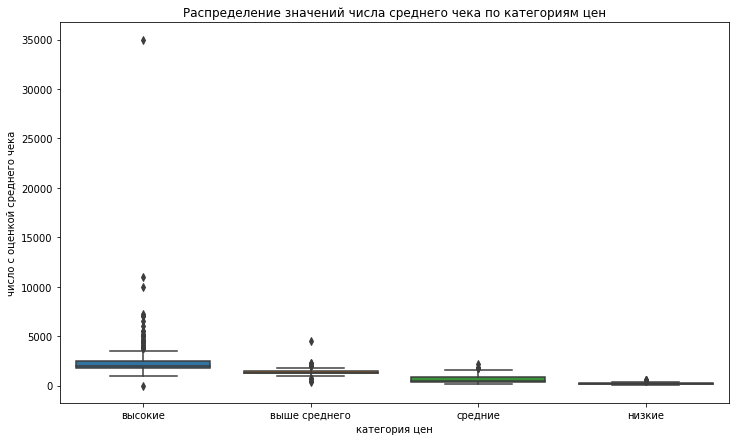

In [18]:
# Построим график boxplot 

# Посчитаем медиану для каждой категории
medians_category_by_mab = df_price.groupby('price')['middle_avg_bill'].median().sort_values(ascending = False)

# Получим порядок категорий, отсортированный по медиане
category_order_medians = medians_category_by_mab.index.tolist()

# Создаём график с сортировкой по медиане
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_price,
    x='price',
    y='middle_avg_bill',
    order=category_order_medians  # передаём отсортированный порядок 
)
plt.title("Распределение значений числа среднего чека по категориям цен")
plt.xlabel('категория цен')  
plt.ylabel('число с оценкой среднего чека')
plt.show()

Больше всего выбросов содержится в категории цен "высокие" и "выше среднего". Построим аналогичный график, исключив выбросы в данных.

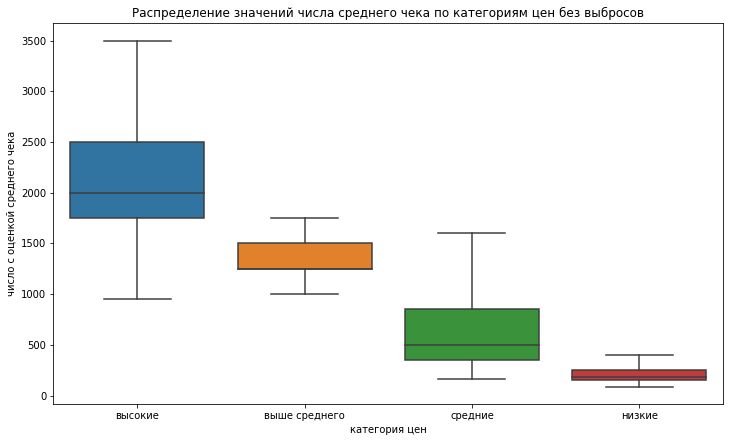

In [19]:
# Построим график boxplot, исключив выбросы. 

# Создаём график с сортировкой по медиане
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_price,
    x='price',
    y='middle_avg_bill',
    showfliers=False,
    order=category_order_medians  # передаём отсортированный порядок 
)
plt.title("Распределение значений числа среднего чека по категориям цен без выбросов")
plt.xlabel('категория цен')  
plt.ylabel('число с оценкой среднего чека') 
plt.show()

Наблюдаемый максимум числа с оценкой среднего чека, которое можно принять для исследования, составляет 3500 р.

С целью проверки возможности заполнения пропусков в столбцах 'price' и 'middle_avg_bill' посмотрим, как соотносятся эти значения. 

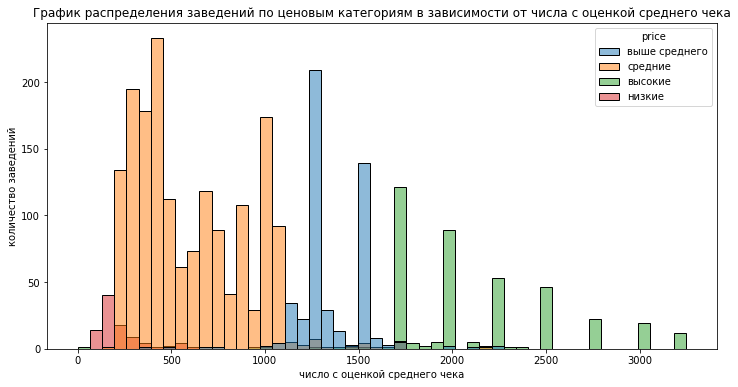

In [20]:
# Построим гистограмму распределения
plt.figure(figsize=(12, 6))
sns.histplot(data = df_price[df_price['middle_avg_bill']<3500], x='middle_avg_bill', hue='price', legend=True, bins = 50) 
plt.title('График распределения заведений по ценовым категориям в зависимости от числа с оценкой среднего чека')
plt.ylabel('количество заведений')
plt.xlabel ('число с оценкой среднего чека')
plt.show()

Данные содержат большое количество пересечений, что может свидетельствовать об отсутствии единого подхода к категоризации заведений по ценам и отсутствии требований к порядку заполнения данных, попадающих в avg_bill, так как на основании этих данных заполняется столбец middle_avg_bill. 

----------------
### Итоги обработки пропусков

**Вероятные причины пропусков:** так как датасеты составлены на сонове данных сервисов Яндекс Карты и Яндекс Бизнес (для последнего - информация могла быть добавлена пользователями) или найдена в общедоступных источниках - заполнение некоторых полей ка в отсутствие утвержденной категоризации и методики могло проводиться пользователями субъективно, или не заполняться вовсе.

В данных содержалось значительное количество пропусков. Для следующих стоблбцов восполнение пропусков видится невозможным и нецелесообразным, так как может исказить выводы:

- hours : данные значения индивидуальны для каждого заведения;
- seats : значение данного столбца не может быть восстановлено, так как напрямую зависит от площади помещения;
- price : отсутствует методика распределения заведений по обозначенным категориям, распределение может зависить от множества факторов, в том числе от расположения заведения;
- middle_avg_bill : аналогично с price. К тому же визуализация распределения занчений числа с оценкой среднего чека и категории цен в заведении показала, что значения пересекаются;

В связи с тем, что исследование не предполагает использование следующих слолбцов, они были удалены: 
- avg_bill : данные представлены в текстовом формате и не имеют единообразоного подхода к опрелелению параметра среднего счета (в части данных это модет быть диапазон, в части - нижняя граница), к тому же в отсутствии информации о том, как производится расчет (на одного клиента или по количеству заказов), этот параметр не является информативным;
- middle_coffee_cup' (87%) - число с оценкой одной чашки капучино, которое указано только для значений из столбца avg_bill, начинающихся с подстроки «Цена одной чашки капучино».

**Рекомендации:** с целью упрощения дальнейшего анализа стоит предоставить пользователям возможность заполнять информацию о заведениях из списка утвержденных для каждого поля значений (например, для категории 'price' утвердить перечень категорий заведений в зависимости от цены, для 'avg_bill' - диапазоны значений среднего чека). Кроме того, при заполнении "карточки заведений" влядельцам необходимо в обязательном порядке указывать режим работы и количество посадочных мест. Также стоит добваить отдельный столбец в данных, содержащий информацию, работает заведение круглосуточно на ежедневной основе или нет.

-----------------

###  Проверим явные и неявные дубликаты в данных

In [21]:
# Приведем значения столбца name в датафрейме df_info к единому написанию 
df_info['name'] = df_info['name'].str.lower().str.replace(" ", "_").str.strip()

In [22]:
# Приведем значения столбца address в датафрейме df_info к единому написанию
df_info['address'] = df_info['address'].str.lower().str.replace(" ", "_").str.replace(",", "_").str.strip()

In [23]:
# Проверяем полные дубликаты в датафрейме df_info
df_info.duplicated().sum()

0

In [24]:
# Проверим дубликаты по столбцам name и address в датафрейме df_info совокупно, чтобы исключить дублирующие заведения
duplicates = df_info[df_info.duplicated(subset=['name', 'address'], keep=False)]
display(duplicates)

,id,name,category,address,district,hours,rating,chain,seats
189,072032ce16dc47bfbc63b672c75bd371,кафе,кафе,москва__парк_ангарские_пруды,Северный административный округ,"ежедневно, 09:00–23:00",3.2,0,<NA>
215,897ddbc6746c4388b19dc8a9fcdbb488,кафе,кафе,москва__парк_ангарские_пруды,Северный административный округ,"ежедневно, 10:00–22:00",3.2,0,<NA>
1430,62608690e9cc464fbcd980cfd552e334,more_poke,ресторан,москва__волоколамское_шоссе__11__стр._2,Северный административный округ,"ежедневно, 09:00–21:00",4.2,0,188
1511,a69f018d5c064873a3b491b0121bc1b4,more_poke,ресторан,москва__волоколамское_шоссе__11__стр._2,Северный административный округ,"пн-чт 09:00–18:00; пт,сб 09:00–21:00; вс 09:00...",4.2,1,188
2211,c6ef39ae8a8c483d8f9a6531bc386a2c,раковарня_клешни_и_хвосты,ресторан,москва__проспект_мира__118,Северо-Восточный административный округ,"ежедневно, 12:00–00:00",4.4,0,150
2420,aba1de7ad7d64ac0a3f8684bda29d905,раковарня_клешни_и_хвосты,"бар,паб",москва__проспект_мира__118,Северо-Восточный административный округ,"пн-чт 12:00–00:00; пт,сб 12:00–01:00; вс 12:00...",4.4,1,150
3091,3c2a73ea79a04be48858fab3685f2f37,хлеб_да_выпечка,булочная,москва__ярцевская_улица__19,Западный административный округ,"ежедневно, 09:00–22:00",4.1,1,276
3109,d3116844e4e048f99614eb30be3214e0,хлеб_да_выпечка,кафе,москва__ярцевская_улица__19,Западный административный округ,NaN,4.1,0,276


Выявлено, что часть заведений с одинаковым названием и адресом имеют разные данные о режиме работы или категории. Указанные данные являются неявными дубликатами.

In [25]:
# Посчитаем количество неявных дубликатов в датафрейме df_info
df_info.duplicated(subset=['name','address'], keep='first').sum()

4

In [26]:
# Удалим неявные дубликаты
df_info = df_info.drop_duplicates(subset=['name', 'address'], keep='first')

In [27]:
# Проверяем полные дубликаты в датафрейме df_price
df_price.duplicated().sum()

0

In [28]:
# Посчитаем количество уникальных значений в столбце id в датафрейме df_info
unique_id = df_info['id'].nunique()
print(unique_id)

8402


In [29]:
# Посчитаем количество уникальных значений в столбце name в датафрейме df_info
unique_name = df_info['name'].nunique()
print(unique_name)

5512


Количество уникальных наименований меньше числа id, что связано с наличием в датасете сетевых заведений.

In [30]:
# Проверяем уникальные значения в категориальных столбцах в датасете df_info
for column in ['district', 'category', 'rating', 'hours']:
    print(f'Уникальные значения в столбце {column}:')
    print(df_info[column].sort_values().unique())
    print()

Уникальные значения в столбце district:
['Восточный административный округ' 'Западный административный округ'
 'Северный административный округ'
 'Северо-Восточный административный округ'
 'Северо-Западный административный округ'
 'Центральный административный округ'
 'Юго-Восточный административный округ'
 'Юго-Западный административный округ' 'Южный административный округ']

Уникальные значения в столбце category:
['бар,паб' 'булочная' 'быстрое питание' 'кафе' 'кофейня' 'пиццерия'
 'ресторан' 'столовая']

Уникальные значения в столбце rating:
[1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7
 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5
 4.6 4.7 4.8 4.9 5. ]

Уникальные значения в столбце hours:
['Нет информации'
 'вт 08:30–17:00; ср,чт 12:00–20:30; пт 08:30–17:00; сб 09:00–16:30'
 'вт 13:00–21:00; ср 11:00–20:00; чт 13:00–21:00; пт-вс 11:00–20:00' ...
 'чт круглосуточно, перерыв 10:00–20:00; сб круглосуточно'
 'чт-вс 20:00–06:00' nan

Значения столбцов 'district', 'category' уникальны и не содержат ошибок в написании. 
Занчения столбца 'rating' имеют занчения от 1 до 5 с точностью до десятой доли.
Значения столбца 'hours' не унифицированы, представлены большим количеством вариаций.

In [31]:
# Посчитаем количество уникальных значений в столбце hours в датафрейме df_info
unique_hours = df_info['hours'].nunique()
print(unique_hours)

1306


In [32]:
# Для создания столбца с признаком работы заведения в круглосуточном режиме выведем значения столбца hours, 
# содержащие значение "круглосуточно", для проведения дальнейшей фильтрации

print('\n'.join(val for val in df_info['hours'].drop_duplicates() if 'круглосуточно' in str(val)))

ежедневно, круглосуточно
пн 00:01–12:00, перерыв 12:00–13:30; вт-чт 13:30–12:00; пт 13:30–00:00; сб,вс круглосуточно
вт-вс круглосуточно
сб круглосуточно
пт-вс круглосуточно
пн,ср,чт,пт,сб,вс круглосуточно
пн 10:00–00:00; вт-сб круглосуточно; вс 00:00–23:00
пн-чт 07:30–23:00; пт 07:30–00:00; сб круглосуточно; вс 00:00–23:00
пн круглосуточно; вт-чт 12:00–00:00; пт 12:00–02:00; сб 11:00–02:00; вс 14:00–00:00
пн-чт 08:00–23:00; пт,сб круглосуточно; вс 08:00–23:00
пн-ср 07:00–23:00; чт 07:00–00:00; пт,сб круглосуточно; вс 00:00–23:00
пн-чт 08:00–23:00; пт 08:00–00:00; сб круглосуточно; вс 00:00–23:00
пн 08:00–23:00; вт-пт 08:00–00:00; сб круглосуточно; вс 00:00–23:00
пн-ср 09:00–00:00; чт-вс круглосуточно
пн-чт круглосуточно; пт 00:00–05:00, перерыв 05:00–07:00; сб 07:00–05:00; вс 07:00–00:00
пн-чт 11:00–23:00; пт 11:00–00:00; сб круглосуточно; вс 00:00–23:00
пн,вт 08:00–22:00; ср,чт 08:00–23:00; пт,сб круглосуточно; вс 00:00–22:00
пн-чт 07:00–23:00; пт,сб круглосуточно; вс 08:00–23:00
пн,

In [33]:
# Создадим столбец с признаком работы заведения в круглосуточном режиме
df_info['is_24_7'] = df_info['hours'].apply(lambda x: True if x == 'ежедневно, круглосуточно' else False)

Для проведения всестороннего исследования объединим датафреймы, сохранив всю информацию.

In [34]:
# Объединим датафреймы с помощью функции megre по столбцу id c помощью аргумента outer для сохранения полной информации.
df = pd.merge(df_info, df_price, on = 'id', how = 'outer')

In [35]:
# Выведем информацию об объединенном датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8402 entries, 0 to 8401
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               8402 non-null   object 
 1   name             8402 non-null   object 
 2   category         8402 non-null   object 
 3   address          8402 non-null   object 
 4   district         8402 non-null   object 
 5   hours            7867 non-null   object 
 6   rating           8402 non-null   float64
 7   chain            8402 non-null   int64  
 8   seats            4792 non-null   Int64  
 9   is_24_7          8402 non-null   bool   
 10  price            3315 non-null   object 
 11  middle_avg_bill  3149 non-null   float64
dtypes: Int64(1), bool(1), float64(2), int64(1), object(7)
memory usage: 804.1+ KB


-----
### Итоги обработки дубликатов

В данных отсутствуют явные дубликаты. Выявлено 4 неявных дубликата, которые были удалены. Создан новый столбец 'is_24_7', содаержащий признак работы заведения в круглосуточном формате. Датафреймы объединены в один для дальнейшего всестороннего анализа. 

----------

## Исследовательский анализ данных

### Какие категории заведений представлены в данных? Исследуйте количество объектов общественного питания по каждой категории. Результат сопроводите подходящей визуализацией.

Для наглядности приведем карту административных округов и районов г. Москвы по состоянию на 2022 год.

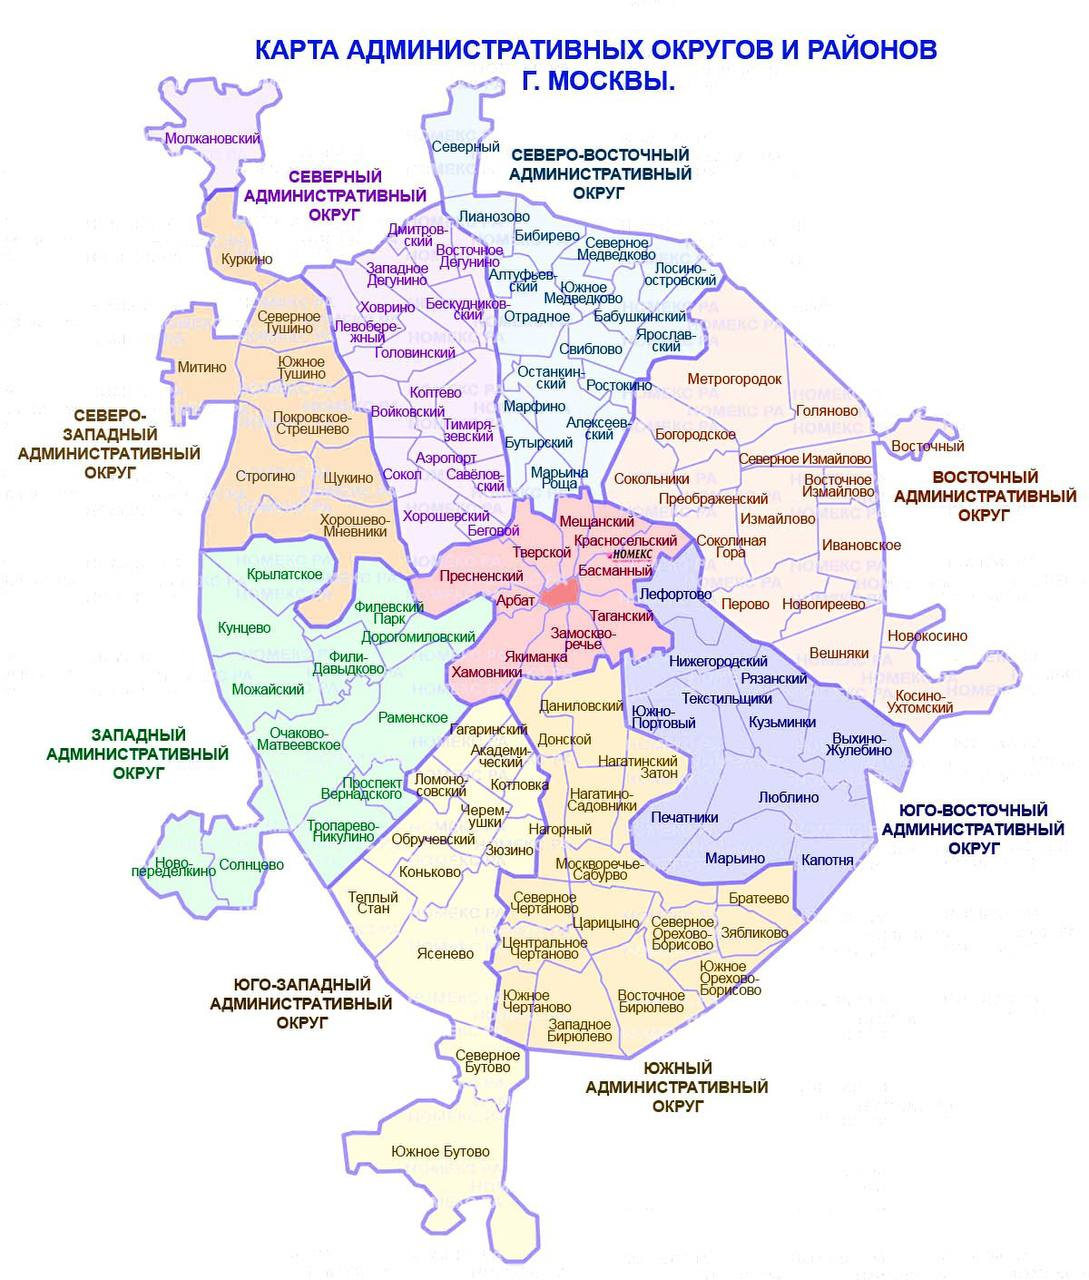

----
Центральный административный округ является самым маленьким по площади. За исключением Центрального административного округа, границы которого равноудалены от центра, остальные округа имеют вытянутую форму, и радиус удаленности от центра имеет больший размах для расположения заведений в этих округах. 

----

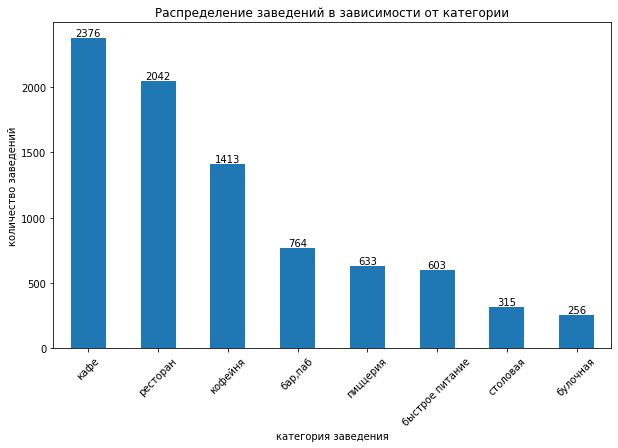

In [36]:
# Построим столбчатую диаграмму для визуализации распределения заведений по категориям.

ax=df['category'].value_counts().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=45, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду,
               title=f'Распределение заведений в зависимости от категории',
               figsize=(10,6)
)
# Убираем сетку
ax.grid(False)

# Настраиваем оформление графика
plt.xlabel('категория заведения') 
plt.ylabel('количество заведений')

# Добавляем подписи данных для столбцов
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

# Выводим график
plt.show()

Все заведения распределены среди 8 категорий: 
 - бар,паб;
 - булочная;
 - быстрое питание;
 - кафе;
 - кофейня;
 - пиццерия;
 - ресторан;
 - столовая.

Самыми популярными категориями заведений оказались: "кафе" (2378 шт.), "ресторан" (2043 шт.), "кофейня" (1413 шт.). 

Самыми непопулярными категорями стали: "булочная" (256 шт.) и "столовая" (315 шт.)

### Какие административные районы Москвы присутствуют в данных? Исследуйте распределение количества заведений по административным районам Москвы, а также отдельно распределение заведений каждой категории в Центральном административном округе Москвы. Результат сопроводите подходящими визуализациями.


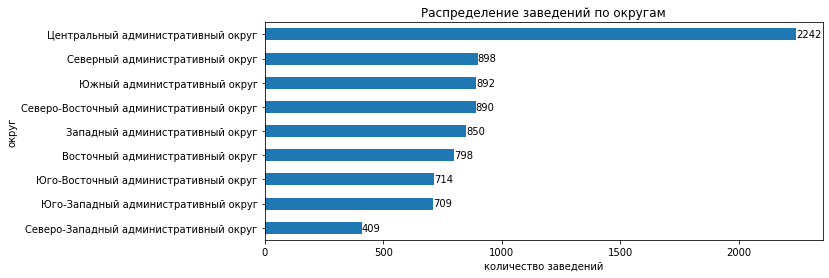

In [37]:
# Построим горизонтальную столбчатую диаграмму 
# для визуализации распределения заведений между округами Москвы.

# Получим распределение и отсортируем огруга по убыванию количества заведений
district_counts = df['district'].value_counts()
district_counts = district_counts.iloc[::-1]

# Построим график на основе отсортированных данных
ax = district_counts.plot(
    kind='barh', 
    rot=0,
    legend=False,
    title='Распределение заведений по округам',
    figsize=(10, 4)
)

# Убираем сетку
ax.grid(False)

# Настраиваем подписи
plt.xlabel('количество заведений')
plt.ylabel('округ')

# Добавляем подписи к столбцам
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f'{int(width)}', (width, y), ha='left', va='center')

# Показываем график
plt.show()

---------

Москва разделена на 9 административно-территориальных округов. 

*Больше* всего заведений общественного питания находится в Центральном административном округе (2242 шт.). 

Количество заведений в Северном (898 шт.), Южном (892 шт.), Свеверо-Восточном 890 шт.) административных округах *практически равное*.

*Меньше* всего - в Северо-Западном администативном округе (409 шт.)

---------

***Отдельно исследуем распределение заведений общественного питания по категориям в Центральном административном округе.***

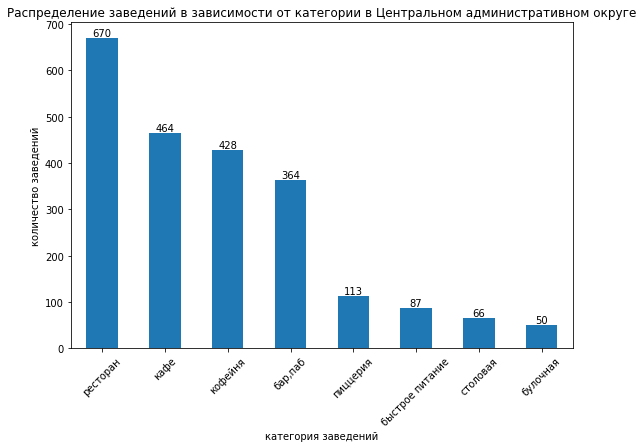

In [38]:
# Построим столбчатую диаграмму распределения заведений по категориям 
# в Центральном административнном округе.

# Отфильтруем данные, оставим только значения для Центрального административного округа
ax=df[df['district'] == 'Центральный административный округ']['category'].value_counts().plot(
               kind='bar', # Тип графика - столбчатая диаграмма
               rot=45, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Распределение заведений в зависимости от категории в Центральном административном округе',
               figsize=(9,6)
)

# Убираем сетку
ax.grid(False)

# Настраиваем оформление графика
plt.xlabel('категория заведений') 
plt.ylabel('количество заведений')

# Добавляем подписи данных для столбцов
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')
# Выводим график
plt.show()

-----------

Всего на Центральный административный округ приходится 2242 заведения общественного питания (26,7% от общего количества по г. Москва). В отличае от общей статистики, где на первом месте находятся "кафе", а потом "рестораны", в Центральном администативном округе "рестораны" находятся на 1 месте (670 шт.), далее идут "кафе" (464 шт.). Расположение остальных заведений по количеству совпадает с общей статистикой, "булочные" (50 шт.) и "столовые" (66 шт.) занимают последние места.

Конкуренция в Центральном административном округе может оказаться самой высокой, так как в самом маленьком округе сосредоточено 26,7% всех заведений общественнного питания.

-----

### Изучите соотношение сетевых и несетевых заведений в целом по всем данным и в разрезе категорий заведения. Каких заведений больше — сетевых или несетевых? Какие категории заведений чаще являются сетевыми? Исследуйте данные, ответьте на вопросы и постройте необходимые визуализации.

In [39]:
# Посчитаем количество сетевых и несетевых завеедений в абсолютных значениях
chain_count = df['chain'].value_counts(normalize=False)
print(chain_count)


0    5199
1    3203
Name: chain, dtype: int64


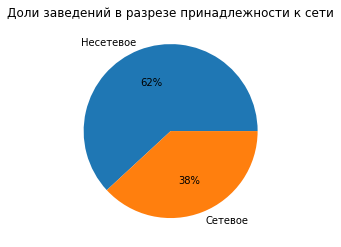

In [40]:
# Посчитаем доли заведений в разрезе принадлежности к сети, построим круговую диаграмму
chain_prop = df['chain'].value_counts(normalize=True)

labels = ['Несетевое', 'Сетевое']
plt.pie(chain_prop, labels=labels,  autopct='%.0f%%')
plt.title("Доли заведений в разрезе принадлежности к сети")
plt.show()

----

Несетевых заведений в общем количестве заведений больше, чем сетевых. 

Всего работает 3203 сетевых заведения (или 38%) и 5199 несетевых заведения (62%).

--------

**Построим столбчатую диаграмму, где отразим соотношение долей сетевых и несетевых заведений в каждой категории заведени, упорядочив категории по убыванию значения общего количества заведений.**

-------------

In [41]:
# Отсортируем категории по убыванию общего количества заведений в категории
category_order = df.groupby('category')['chain'].count().sort_values(ascending=False).index.tolist()

# Построим DataFrame с долями, с правильным порядком категорий
distribution = df.groupby('category')['chain'].value_counts(normalize=True).unstack(fill_value=0)

# Убедимся, что категории идут в нужном порядке
distribution = distribution.loc[category_order]

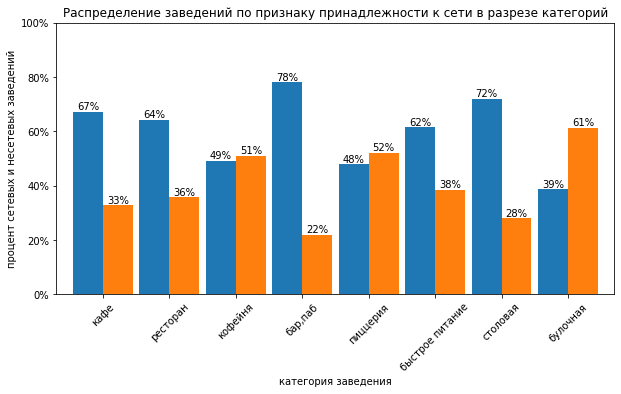

In [42]:
# Построим столбчатую диаграмму для визуализации распределения заведений по признаку принадлежности к сети в разрезе категорий.

# Построение графика с вычислением долей (процентов)
ax = distribution.plot(
    kind='bar',
    rot=45,
    legend=False,
    title='Распределение заведений по признаку принадлежности к сети в разрезе категорий',
    width=0.9,
    figsize=(10, 5)
)

ax.grid(False)

plt.xlabel('категория заведения')
plt.ylabel('процент сетевых и несетевых заведений')


# Добавляем подписи в процентах
for p in ax.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    y = height + 0.001  # чуть выше вершины
    percentage = height * 100
    ax.annotate(f'{percentage:.0f}%', (x, y), ha='center', va='bottom')

# Устанавливаем метки оси Y в диапазоне 0-80%
ax.set_ylim(0, 0.8)
ax.yaxis.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'])



plt.show()

-----------------

Доля сетевых зваедений составляет 38%.
Более половины всех пиццерий, кофеен и булочных являются сетевыми заведениями. Около трети ресторанов, кафе, заведений быстрого питания являются сетевыми заведениями. Меньше всего сетевых заведений встречается в категориях бар, паб и столовая. 

--------------

### Исследуйте количество посадочных мест в заведениях. Встречаются ли в данных аномальные значения или выбросы? Если да, то с чем они могут быть связаны? Приведите для каждой категории заведений наиболее типичное для него количество посадочных мест. Результат сопроводите подходящими визуализациями.

In [43]:
# Выведем статистические показатели для столбца seats
df['seats'].describe()

count    4792.000000
mean      108.361436
std       122.841130
min         0.000000
25%        40.000000
50%        75.000000
75%       140.000000
max      1288.000000
Name: seats, dtype: float64

Данные сожержат большой разброс, о чем свидетельствует большая разница между минимальным и максимальным занчением, медианой и средним, а также показетель стандартного отклонения. Построим boxplot для каждой категории заведений, а также рассчитаем медиану для опредедения наиболее типичного количества посадочных мест для каждой категории.

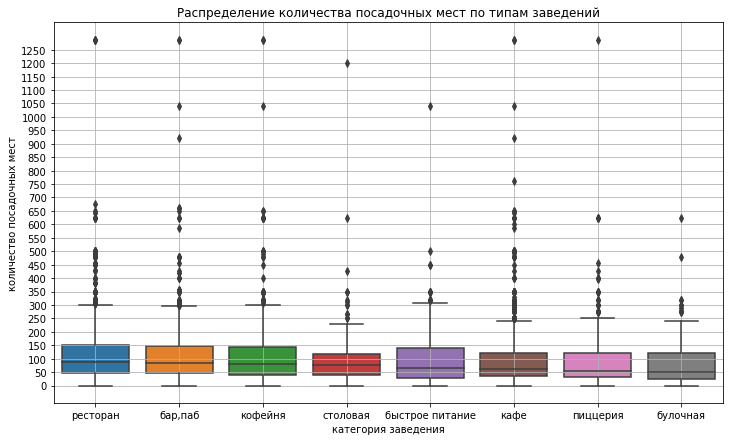

In [44]:
# Вычисляем медианы данных столбца seats в разрезе категорий
medians_category_seats = df.groupby('category')['seats'].median().sort_values(ascending = False)

# Получим порядок категорий, отсортированный по медианам
category_order_seats = medians_category_seats.index.tolist()

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 7))

sns.boxplot(data=df, x='category', y='seats', order = category_order_seats)
plt.title("Распределение количества посадочных мест по типам заведений")
plt.xlabel ('категория заведения') 
plt.ylabel ('количество посадочных мест')
plt.yticks(range(int(df['seats'].min()), int(df['seats'].max()) + 1, 50)) # зададим метки по оси Y
plt.grid()

plt.show()

Данные содержат большое количество выбросов, что может быть связано, как с ошибками в данных при ручном внесении информации, неправильном определении категории заведения, так и отсутствием ошибок: например, ряд помещений действительно может иметь  большое количество мест (банкетные залы для проведения массовых мероприятий; наличие веранд и террас в теплое время года). 

Для изучения данных внутри категорий и удобства сравнения построим график без выбросов в данных.

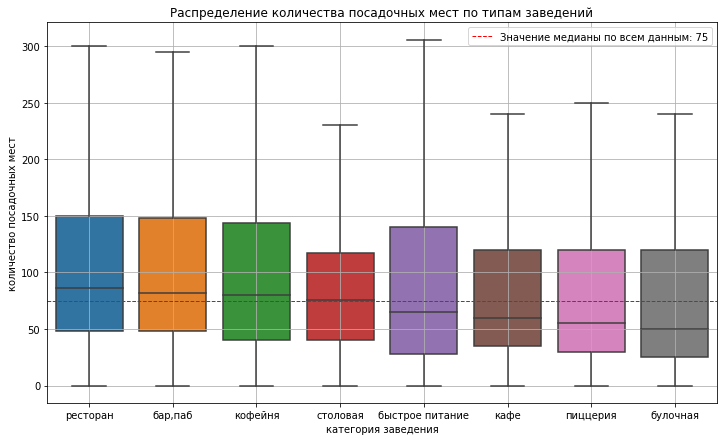

In [45]:
# Вычисляем общую медиану данных столбца seats
median_seats = df['seats'].median().astype('int64')

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 7))

# Уберем выбросы в данных при построении графика
sns.boxplot(data=df, x='category', y='seats', showfliers=False, order = category_order_seats)
plt.title("Распределение количества посадочных мест по типам заведений")
plt.xlabel ('категория заведения') 
plt.ylabel ('количество посадочных мест')
plt.grid()

# Нанесем линию медианы всех данных столбца seats
plt.axhline(median_seats, color='red',
            linestyle='--', linewidth=1,
            label=f'Значение медианы по всем данным: {median_seats}')
plt.legend()

plt.show()

In [46]:
# Выведем подробные показатели 
medians_seats = df.groupby('category')['seats'].median().astype('int64') 
q1 = df.groupby('category')['seats'].quantile(0.25).astype('int64')
q3 = df.groupby('category')['seats'].quantile(0.75).astype('int64')

result = pd.DataFrame({
    'Median': medians_seats,
    'Q1': q1,
    'Q3': q3
})

print(f"Детализация значений каждой категории: \n {result}")


Детализация значений каждой категории: 
                  Median  Q1   Q3
category                        
бар,паб              82  48  148
булочная             50  25  120
быстрое питание      65  28  140
кафе                 60  35  120
кофейня              80  40  144
пиццерия             55  30  120
ресторан             86  48  150
столовая             75  40  117


------

Все категории имеют ассиметричное распреледеление данных со смещением влево, что свидетельствует о том, что заведения чаще имеют небольшое количество мест. Медианные значения категорий "ресторан", "кофейня", "бар, паб", "быстрое питание", "столовая" приближены к общей медиане (75 посадочных мест). Медианные значения категорий "кафе", "пиццерия" и "булочная" ниже (около 55 посадочных мест).

------

### Исследуйте рейтинг заведений. Визуализируйте распределение средних рейтингов по категориям заведений. Сильно ли различаются усреднённые рейтинги для разных типов общепита?

In [47]:
# # Выведем статистические показатели для столбца rating
df['rating'].describe()

count    8402.000000
mean        4.230017
std         0.470320
min         1.000000
25%         4.100000
50%         4.300000
75%         4.400000
max         5.000000
Name: rating, dtype: float64

Медиана и среднее столбца рейтинг практически не отличаются, что свидетельствует о небольшом разбросе данных.

***Построим график boxplot для анализа рейтинга в разрезе категорий заведений.***

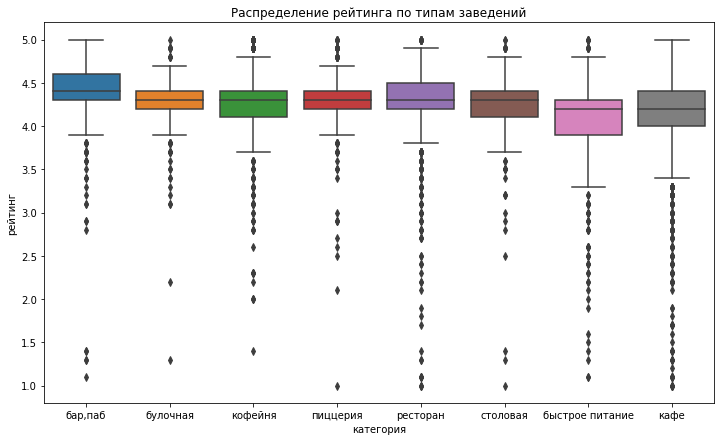

In [48]:
# Расчитаем медианный рейтинг по каждой категории
category_by_rating_medians = df.groupby('category')['rating'].median().round(2)

# Создаем список категорий, отсортированный по убыванию среднего
category_order_rating_mrdian = category_by_rating_medians.sort_values(ascending=False).index.tolist()

# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 7))
# Создаем график и определяем его параметры
sns.boxplot(data=df, x='category', y='rating', order=category_order_rating_mrdian)
plt.title("Распределение рейтинга по типам заведений")
plt.xlabel ('категория') # пустая подпись для оси Х
plt.ylabel ('рейтинг') # пустая подпись для оси Y

plt.show()

Выбросы в данных содержатся преимущественно в нижний значениях. Однако, такие значения рейтинга могут быть объективными значениями. В данной ситуации значение среднего рейтинга по категориям будет покзывать более объективную картину.

In [49]:
# Расчитаем средний рейтинг по каждой категории
category_by_rating_means = df.groupby('category')['rating'].mean().round(2)
print('Среднее значение рейтинга в категориях:')
print(category_by_rating_means.sort_values(ascending=False))

# Расчитаем средний рейтинг по всем категорииям
mean_rating = df['rating'].mean()
print(f'Средний рейтинг по всем заведениям {mean_rating.round(3)}')

# Создаем список категорий, отсортированный по убыванию среднего
category_order_rating = category_by_rating_means.sort_values(ascending=False).index.tolist()


Среднее значение рейтинга в категориях:
category
бар,паб            4.39
пиццерия           4.30
ресторан           4.29
кофейня            4.28
булочная           4.27
столовая           4.21
кафе               4.12
быстрое питание    4.05
Name: rating, dtype: float64
Средний рейтинг по всем заведениям 4.23


Значения среднего рейтинга категорий сосредоточены в диапазоне от 4.05 до 4.39. Построим столбчатую диаграмму, для наглядности зададим начальное значение оси Y равное 4, чтобы были видны различия.

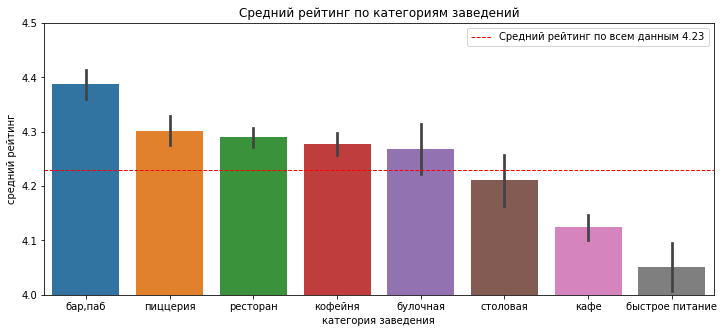

In [50]:
# Построим столбчатую диаграмму соотношения среднего рейтига категорий

plt.figure(figsize=(12, 5))
sns.barplot(
    x='category',
    y='rating',
    data=df,
    order=category_order_rating
)

plt.title("Средний рейтинг по категориям заведений")
plt.xlabel('категория заведения')
plt.ylabel('средний рейтинг')

# Устанавливаем диапазон по оси Y, начиная с 4
plt.ylim(4, 4.5)


# Линия среднего рейтинга по всему датафрейму
mean_rating = df['rating'].mean()
plt.axhline(mean_rating, color='red', linestyle='--', linewidth=1,
            label=f'Средний рейтинг по всем данным {mean_rating:.2f}')
plt.legend()
plt.show()

-----------

Согласно графику средние значения рейтинга распределены следующим образом:
- самый высокий средний рейтинг в категории "бар,паб" (4.39); 
- в категориях "пиццерия" (4.30), "ресторан" (4.29), "кофейня" (4.28), "булочная" (4.27) средний рейтинг также выше среднего по всем данным;
- в категориях "столовая" (4.21), "кафе" (4.12), "быстрое питание" (4.05) средний рейтинг ниже среднего по всем значениям.

-----------

### Изучите, с какими данными показывают самую сильную корреляцию рейтинги заведений? Постройте и визуализируйте матрицу корреляции рейтинга заведения с разными данными: его категория, положение (административный район Москвы), статус сетевого заведения, количество мест, ценовая категория и признак, является ли заведения круглосуточным. Выберите самую сильную связь и проверьте её.

In [51]:
# Построим матрицу корреляции рейтинга заведения с помощью библиотеки для расчёта коэффициента корреляции phi_k
# Выбираем нужные колонки
selected_columns = ['category', 'district', 'rating', 'chain', 'seats', 'price', 'is_24_7']

# Создаём матрицу корреляции по выбранным колонкам
corr_matrix = df[selected_columns].phik_matrix()

# Исключаем строку 'rating', чтобы не сравнивать рейтинг сам с собой
rating_correlations = corr_matrix.loc[corr_matrix.index != 'rating', ['rating']]

# Сортируем по убыванию корреляции
sorted_rating_corr = rating_correlations.sort_values(by='rating', ascending=False)


interval columns not set, guessing: ['rating', 'chain', 'seats']


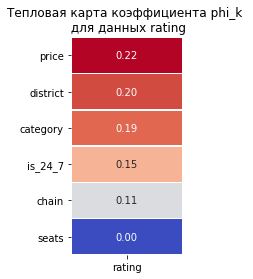

In [52]:
# Построим тепловую карту 
plt.figure(figsize=(2, 4))

# Сохраняем матрицу корреляции признака rating 
data_heatmap = sorted_rating_corr
sns.heatmap(data_heatmap,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.2f', # Форматируем значения корреляции: два знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5, # Форматируем линию между ячейками карты
            cbar=False # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для данных rating')

# Выводим график
plt.show()

Между рейтингом и другими переменными не обнаружено сильной корреляции. 
- price (0.22) слабая положительная связь. Можно предположить, что чем выше категория цен в заведении, тем более высокий рейтинг.
- district (0.20) оценивается как слабая положительная связь. Можно предположить, что расположение влияет влияет на рейтинг.
- category (0.19): слабая связь, разные категории могут немного влиять на рейтинг.
- is_24_7 (0.15): почти нет связи.
- chain (0.11): очти нет связи.
- seats (0.00) : нет связи. Количество мест никак не вляияет на рейтинг заведения.

*Построим визуализации связей между рейтингом и категорией цен в заведении и местоположением.*

In [53]:
# Присвоим значениям столбца 'price' числовые значения, напишем функцию.

def categorize_price(score):
    if score == 'высокие':
        return 4
    elif score == 'выше среднего':
        return 3
    elif score == 'средние':
        return 2
    else:
        return 1

# Применение функции к данным
df['price_category'] = df['price'].apply(categorize_price)

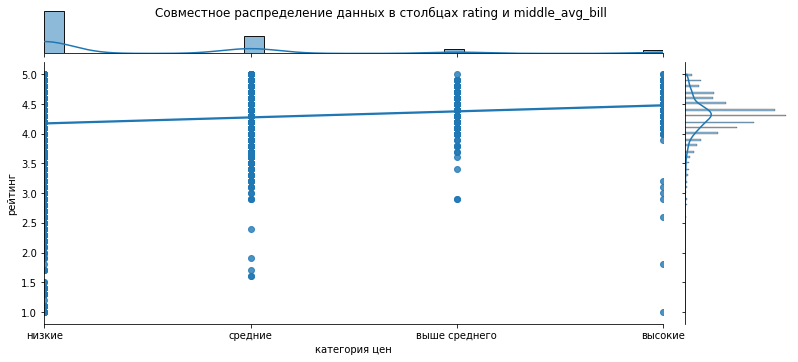

In [54]:
# Построим график совместного распределения данных рейтинга и категории цен в заведениях

# Построение графика
g = sns.jointplot(data=df, x='price_category', y='rating', kind="reg")
g.fig.set_size_inches(12, 5)  # Исправлено здесь

# Установка делений по оси X и подписи
g.ax_joint.set_xticks([1, 2, 3, 4])
g.ax_joint.set_xticklabels(['низкие', 'средние', 'выше среднего', 'высокие'])
plt.suptitle('Совместное распределение данных в столбцах rating и middle_avg_bill')


# Убираем подписи с осей
g.ax_joint.set_xlabel('категория цен')
g.ax_joint.set_ylabel('рейтинг')



plt.show()

График показывает слабую положительную корреляцию между рейтингом и категориями цен в заведениях: чем выше цены, тем реже присваивают отрицательные рейтинги.

Дополнительно построим график совместного распределения значений рейтинга и числа с оценкой среднего чека, так как этот столбец также содержит сведения о ценах в заведении.

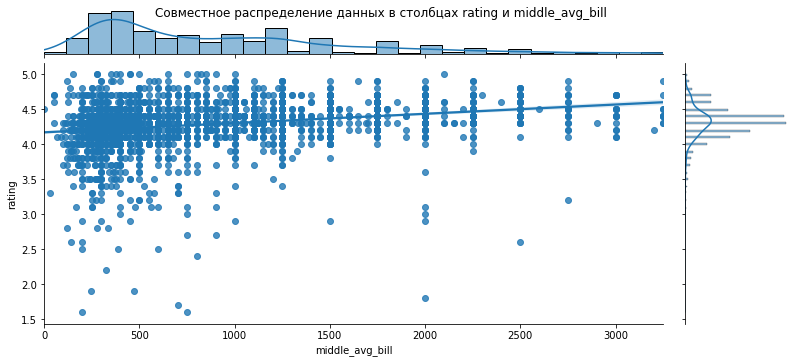

In [55]:
# Построим график совместного распределения данных рейтинга и числа с оценкой среднего чека
# Отфильтруем датафрем, убрав выбросы в столбце middle_avg_bill
sns.jointplot(data=df[df['middle_avg_bill']<3500], x='middle_avg_bill', y='rating', kind="reg")
plt.gcf().set_size_inches(12, 5) 
plt.suptitle('Совместное распределение данных в столбцах rating и middle_avg_bill')

plt.show()

Прослеживается слабая положительная связь: чем выше число с оценкой среднего чека (для четения результатов - равно средний чек), тем реже заведению присваивают рейтинг ниже 4.

*Проверим следующую связь - рейтинг и расположение заведения.*

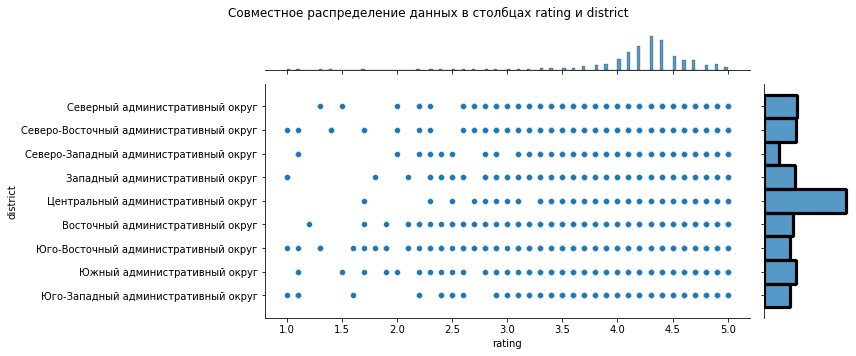

In [56]:
# Построим график совместного распределения данных рейтинга и расположения (округов)
sns.jointplot(data=df, x='rating', y='district', kind='scatter')

# Собираем текущий график
plt.gcf().set_size_inches(12, 5)

# Подписываем и отображаем
plt.suptitle('Совместное распределение данных в столбцах rating и district')

plt.tight_layout()
plt.show()

Из визуализации следует, что заведениям в Центральном, Северо-Западном, Юго-Западном, Западном, Северном административных округе практически не присваивают рейтинг ниже, чем 3. 

В Северо-Восточном, Восточном, Южном и Юго-Восточном административных округах рейтинг ниже 3 присваивают чаще. Вероятно, в таких округах конкуренция будет ниже.


Дополнительно проверим корреляцию с помощью метода Спирмена, так как он менее чувствителен к выбросам в данных.

In [57]:
# Построим корреляционную матрицу с помощью метода Сприрмена
spearman_corr = df[['rating', 'middle_avg_bill', 'seats']].corr(method='spearman')
print('Корреляционная матрица с коэффициентом Спирмена:')
print(spearman_corr)

Корреляционная матрица с коэффициентом Спирмена:
                   rating  middle_avg_bill     seats
rating           1.000000         0.363923  0.025147
middle_avg_bill  0.363923         1.000000  0.173193
seats            0.025147         0.173193  1.000000


Согласно данным корреляционной матрицы связь между рейтингом и ценами (средним чеком) имеет умеренное значение. Предположение, что чем выше средний чек, тем реже пользователи ставят низкие оценки рейтинга, нашло дополнительное подтверждение.
Связь рейтинга и количества посадочных мест по-прежнему слабая (можно сказать, что ее нет), следовательно, корреляция отсутствует.

------------
**Выводы:**
- показатели среднего чека и рейтинг -  значимая связь: заведения с более высоким средним чеком реже имеют низкий рейтинг (ниже 4).
- слабая связь рейтинга также обнаружена с расположением. Однако, для исследования деление территории Москвы на округи не является показательным, так как только для Центрального округа справедлива характеристика равномерной удаленности от центра (площадь Центрального округа меньше остальных округов и точки равноудалены от центра). Остальные округа имеют вытянутую форму и радиус удаленности от центра имеет больший размах для расположения заведений в этих округах.
- oстальные переменные показывают слабую или очень слабую связь.

**Рекомендации:**
Для исследования также было бы важным посмотреть количество оценок пользователей, исходя из которых сформирован средний рейтинг. Эти данные могли бы помочь сформировать предположение о частоте посещений заведений, выдвинуть гипотезу о возможном обороте.

-----------

<div class="alert alert-success">
<b>✔️ Комментарий ревьюера v2:</b>
<br>Отлично! Теперь всё верно)
</div>

### Сгруппируйте данные по названиям заведений и найдите топ-15 популярных сетей в Москве. Для них посчитайте значения среднего рейтинга. Под популярностью понимается количество заведений этой сети в регионе. К какой категории заведений они относятся? Результат сопроводите подходящими визуализациями.

In [58]:
# Отфильтруем данные по признаку приадлежности к сети
chain_df = df[df['chain']==1]

# Посчитаем среднее значение рейтинга для сетевых заведений
mean_rating_chain = chain_df['rating'].mean()
print('Среднее значение рейтинга сетевых заведений:')
print(mean_rating_chain.round(2))

Среднее значение рейтинга сетевых заведений:
4.22


In [59]:
# Проведем группировку данных по названию и принадлежности к категории заведений, посчитаем количество заведений внутри сети
grouped_name = (
    chain_df.groupby(['name','category'], as_index=True)
    .agg(cnt_object=('name', 'count'), mean_rating=('rating', 'mean'))
    .sort_values(by='cnt_object', ascending=False).head(15)
)
# Округление до 2 десятичных знака
grouped_name['mean_rating'] = grouped_name['mean_rating'].round(2)
    
print (grouped_name)

                                              cnt_object  mean_rating
name                                category                         
шоколадница                         кофейня          119         4.18
домино'с_пицца                      пиццерия          76         4.17
додо_пицца                          пиццерия          74         4.29
one_price_coffee                    кофейня           71         4.06
яндекс_лавка                        ресторан          69         3.87
cofix                               кофейня           65         4.08
prime                               ресторан          49         4.11
кофепорт                            кофейня           42         4.15
кулинарная_лавка_братьев_караваевых кафе              39         4.39
теремок                             ресторан          36         4.11
cofefest                            кофейня           31         3.98
чайхана                             кафе              26         3.95
буханка             

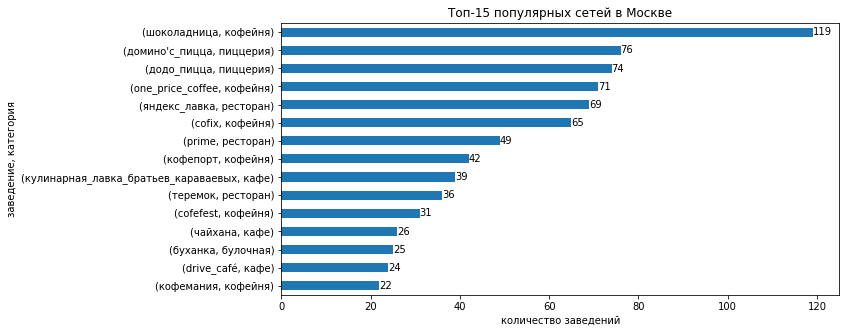

In [60]:
# Построим столбчатую диаграмму для визуализации данных

# Переворачиваем DataFrame, чтобы при построении графика топ-заведения шли сверху вниз
grouped_name = grouped_name.iloc[::-1]

# Строим график
ax=grouped_name['cnt_object'].plot(kind='barh', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Топ-15 популярных сетей в Москве',
               figsize=(10, 5)
)

# Убираем сетку
ax.grid(False)

# Настраиваем оформление графика
plt.xlabel('количество заведений')
plt.ylabel('заведение, категория') 

# Добавляем подписи в конце каждого горизонтального столбца
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f'{int(width)}', (width, y), ha='left', va='center')


# Выводим график
plt.show()

Самой популярной сетью в Москве является "Шоколадница" (119 филиалов, категория "кофейня"). Второе и третье места занимают пиццерии "Домино'с пицца" (76 филиалов) и " Додо пицца" (74 филиала).

Исследуем рейтинг топ-15 популярных заведений.

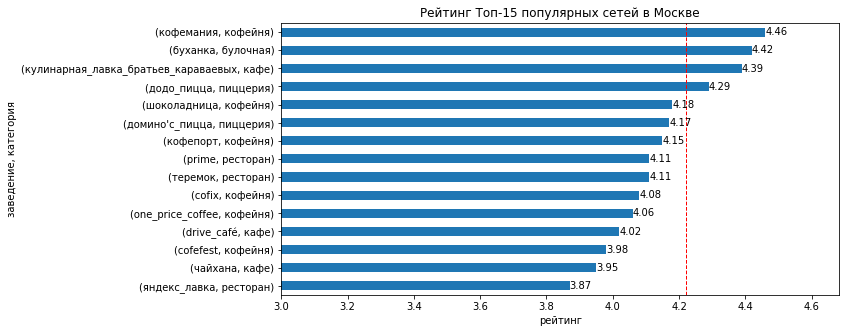

In [61]:
# Построим столбчатую диаграмму для визуализации данных
grouped_name_sorted_rating = grouped_name.sort_values(by='mean_rating', ascending=True)

# Строим график
ax=grouped_name_sorted_rating['mean_rating'].plot(kind='barh', # Тип графика - столбчатая диаграмма
               rot=0, # Градус вращения подписи по оси Х
               legend=False, # Выключаем легенду
               title=f'Рейтинг Топ-15 популярных сетей в Москве',
               figsize=(10, 5)
)
# Убираем сетку
ax.grid(False)

# Настраиваем оформление графика
plt.xlabel('рейтинг')
plt.ylabel('заведение, категория') 

# Устанавливаем диапазон по оси Y, начиная с 3
plt.xlim(3)

# Добавляем подписи в конце каждого горизонтального столбца
for p in ax.patches:
    width = p.get_width()
    y = p.get_y() + p.get_height() / 2
    ax.annotate(f'{width:.2f}', (width, y), ha='left', va='center')

# Добавляем среднее значение рейтинга сетевых заведений
plt.axvline(mean_rating_chain, color='red',
            linestyle='--', linewidth=1,
            label=f'Значение среднего рейтинга по всем данным {mean_rating}')

# Выводим график
plt.show()

---------

Среднее значение рейтинга для сетевых заведений равно 4.22. Только рейтинг заведений 4 сетей  выше среднего значения: "Кофемания" (кофейня) - 4.46; "Буханка" (булочная) - 4.42 и "Кулинарная лавка братьев Караваевых" (кафе) - 4.39; "Додо пицца" (пиццерия) - 4.29. В целом, значения рейтинга заведений всех сетей близки к среднему. Количество заведений внтури сети не влияет на значение рейтига, нет зависимости, что меньшие сети имеют больший рейтинг, и наоборот.
Самой популярной категорией среди топ-15 сетей оказалась "кофейня" (6 шт.)

-------

### Изучите вариацию среднего чека заведения (столбец middle_avg_bill) в зависимости от района Москвы. Проанализируйте цены в центральном административном округе и других. Как удалённость от центра влияет на цены в заведениях? Результат сопроводите подходящими визуализациями.

Медианное значение числа среднего чека:
district
Западный административный округ            1000.0
Центральный административный округ         1000.0
Северо-Западный административный округ      700.0
Северный административный округ             650.0
Юго-Западный административный округ         600.0
Восточный административный округ            575.0
Северо-Восточный административный округ     500.0
Южный административный округ                500.0
Юго-Восточный административный округ        450.0
Name: middle_avg_bill, dtype: float64


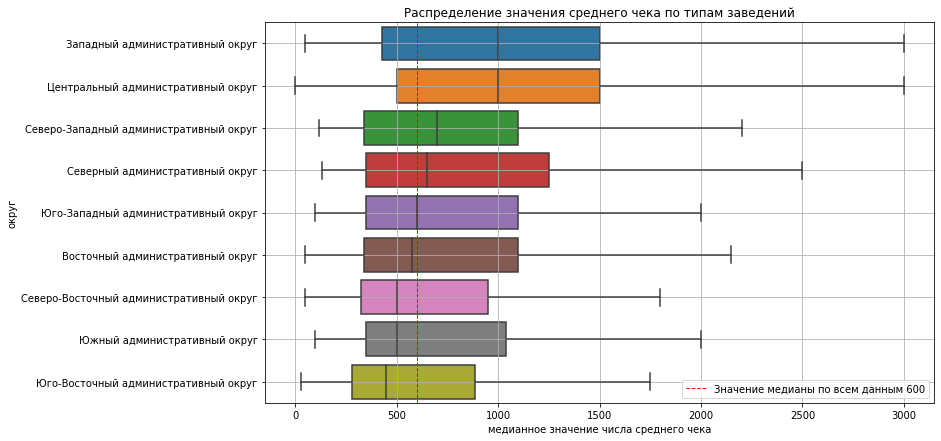

In [62]:
# Вычисляем медиану для каждой категории
median_middle_avg_bill = df.groupby('district')['middle_avg_bill'].median().sort_values(ascending=False)
print('Медианное значение числа среднего чека:')
print(median_middle_avg_bill)

category_order_by_district_mab=median_middle_avg_bill.index.tolist()
# Создаём контейнер графика matplotlib и задаём его размер
plt.figure(figsize=(12, 7))

sns.boxplot(data=df, x='middle_avg_bill', y='district', showfliers=False, order = category_order_by_district_mab)
plt.title("Распределение значения среднего чека по типам заведений")
plt.xlabel ('медианное значение числа среднего чека') 
plt.ylabel ('округ')
plt.grid()

plt.axvline(median_middle_avg_bill.median(), color='red',
            linestyle='--', linewidth=1,
            label=f'Значение медианы по всем данным {median_middle_avg_bill.median():.0f}')
plt.legend()
plt.show()

--------------

Медианное значение среднего чека только в 4 округах Москвы выше, чем общее значение по всем данным: Центральный и Западный административные округа (1000 р), Северо-Западный административный округ (700 р), Северный административный округ (650 р).

------
Ранее уже было отмечено, что  для исследования деление территории Москвы на округа не является показательным, так как только для Центрального округа справедлива характеристика равномерной удаленности от центра . Остальные округа имеют вытянутую форму, и радиус удаленности от центра имеет больший размах для расположения заведений в этих округах. 

В рамках исследования не представляется сделать однозначный вывод о наличии корреляции между удаленностью от центра и ценами в заведениях, так как изначальный формат данных категоризирует расположение по округам и адресам. 

**Рекомендации:**
Деление территоририи Москвы для анализа корреляций удаленности от центра и других данных необходимо провести радиально (можно сегментировать по зонам "колец" (Садовое, ТТК, МКАД, или же распределить районы по сегментам, чтобы границы были равноудалены от центра).

--------

----
## Итоговые выводы

В ходе исследования были проанализированы данные более 8400 заведений общественнго питания г. Москва. Данные были представлены двумя датасетами и включали информацию о наименовании заведения, принадлежности к сети, категории заведения ('бар,паб', 'булочная', 'быстрое питание', 'кафе', 'кофейня', 'пиццерия', 'ресторан', 'столовая), расположении (округ и точный адрес), часах работы, количестве посадочных мест, рейтинге, а также о ценовых параметрах (условное распределение заведений по ценовому сегменту, значения среднего чека и стоимости отдельных позиций). 

Акцент исследования был на том, чтобы определить наиболее подходящее место для открытия заведения.

В ходе предобработки данных было установлено, что в датасетах  присутствует столбец с уникальными идентификатором, наличие которого не было обозначено в описании данных. Впоследствии на основании id (связка наименования и адреса) датафреймы были объеденены в один для возможности полноценного анализа.
Больше всего пропусков содержалось в столбцах, содержащих информацию о часах работы и количестве посадочных мест в заведении, информацию об оценке одной чашки капучино, оценке среднего чека, категории цен в заведении и средней стоимости заказа. 

Для следующих стоблбцов восполнение пропусков было невозможным и нецелесообразным, так как могло исказить выводы:

- hours : данные значения индивидуальны для каждого заведения;
- seats : значение данного столбца не может быть восстановлено, так как напрямую зависит от площади помещения;
- price : отсутствует методика распределения заведений по обозначенным категориям;
- middle_avg_bill : аналогично с price. К тому занчения числа с оценкой среднего чека и категории цен в заведении имели множественные пересечения;

В связи с тем, что исследование не предполагало использование следующих данных, они были удалены: 
- avg_bill : данные представлены в текстовом формате без единообразоного подхода к опрелелению параметра среднего счета (в части данных это может быть диапазон, в части - нижняя граница), к тому же в отсутствии информации о том, как производится расчет (на одного клиента или по количеству заказов), этот параметр не является информативным;
- middle_coffee_cup' (87%) - число с оценкой одной чашки капучино, которое указано только для значений из столбца avg_bill, начинающихся с подстроки «Цена одной чашки капучино».

В данных отсутствовали явные дубликаты. Выявлено 4 неявных дубликата, которые были удалены. Создан новый столбец 'is_24_7', содаержащий признак работы заведения в круглосуточном формате.

**Рекомендации:** стоит предоставить пользователям возможность заполнять информацию о заведениях из списка утвержденных для каждого поля значений (например, для категории 'price' утвердить перечень категорий заведений в зависимости от цены, для 'avg_bill' - диапазоны значений среднего чека). Кроме того, при заполнении "карточки заведений" влядельцам необходимо в обязательном порядке указывать режим работы и количество посадочных мест. Также стоит добваить отдельный столбец в данных, содержащий информацию, работает заведение круглосуточно на ежедневной основе или нет.


**В ходе исследовательского анализа данных были исследованы следующие вопросы:**

***1. Какие категории заведений представлены в данных?***

Все заведения разделены на 8 категорий: 
 - бар,паб;
 - булочная;
 - быстрое питание;
 - кафе;
 - кофейня;
 - пиццерия;
 - ресторан;
 - столовая.

Самыми популярными категориями заведений окалазись: "кафе" (2378 шт.), "ресторан" (2043 шт.), "кофейня" (1413 шт.). 

Самыми непопулярными категорями стали: "булочная" (256 шт.) и "столовая" (315 шт.)

***2. Какие административные районы Москвы присутствуют в данных? Исследуйте распределение количества заведений по административным районам Москвы, а также отдельно распределение заведений каждой категории в Центральном административном округе Москвы.***

Москва разделена на 9 административно-территориальных округов: 
- Восточный административный округ,
- Западный административный округ,
- Северный административный округ,
- Северо-Восточный административный округ,
- Северо-Западный административный округ,
- Центральный административный округ,
- Юго-Восточный административный округ,
- Юго-Западный административный округ,
- Южный административный округ. 

*Больше* всего заведений общественного питания находится в Центральном административном округе (2242 шт.). 

Количество заведений в Северном (898 шт.), Южном (892 шт.), Свеверо-Восточном 890 шт.) административных округах *практически равное*.

*Меньше* всего - в Северо-Западном администативном округе (409 шт.)

Всего на Центральный административный округ приходится 26,7% заведений общественного питания от общего количества по г. Москва. В отличае от общей статистики, где на первом месте находятся "кафе", а потом "рестораны", в Центральном администативном округе "рестораны" находятся на 1 месте (670 шт.), далее идут "кафе" (464 шт.). Расположение остальных заведений по количеству совпадает с общей статистикой, "булочные" (50 шт.) и "столовые" (66 шт.) занимают последние места.

*Конкуренция в Центральном административном округе может оказаться самой высокой, так как в самом маленьком округе сосредоточено 26,7% всех заведений общественнного питания.*


***3. Изучите соотношение сетевых и несетевых заведений в целом по всем данным и в разрезе категорий заведения.***

Доля сетевых зваедений составляет 38%, таким образом несетевых заведений больше.
Более половины всех пиццерий, кофеен и булочных являются сетевыми заведениями. Около трети ресторанов, кафе, заведений быстрого питания являются сетевыми заведениями. Меньше всего сетевых заведений встречается в категориях бар, паб и столовая. 

***4. Исследуйте количество посадочных мест в заведениях. Встречаются ли в данных аномальные значения или выбросы? Если да, то с чем они могут быть связаны? Приведите для каждой категории заведений наиболее типичное для него количество посадочных мест.*** 

Данные содержат большое количество выбросов, присутствуют также аномальные значения (например, 1288 посадочных мест), что может быть связано, как с ошибками в данных при ручном внесении информации, неправильном определении категории заведения, так и отсутствием ошибок: например, ряд помещений может иметь действительно большое количество мест (банкетные залы для проведения массовых мероприятий; наличие веранд и террас в теплое время года). 

Все категории заведений имеют ассиметричное распреледеление данных со смещением влево, что свидетельствует о том, что заведения имеют небольшое количество мест. Медианные значения категорий "ресторан", "кофейня", "бар, паб", "быстрое питание", "столовая" приближены к общей медиане (75 посадочных мест). Медианные значения категорий "кафе", "пиццерия" и "булочная" ниже (около 55 посадочных мест).

***5. Исследуйте рейтинг заведений. Сильно ли различаются усреднённые рейтинги для разных типов общепита?*** 

Значения среднего рейтинга категорий сосредоточены в диапазоне от 4.05 до 4.39. 

Согласно графику средние значения рейтинга распределены следующим образом:
- самый высокий средний рейтинг в категории "бар,паб" (4.39); 
- в категориях "пиццерия" (4.30), "ресторан" (4.29), "кофейня" (4.28), "булочная" (4.27) средний рейтинг также выше среднего по всем данным;
- в категориях "столовая" (4.21), "кафе" (4.12), "быстрое питание" (4.05) средний рейтинг ниже среднего по всем значениям.

***6. С какими данными показывают самую сильную корреляцию рейтинги заведений?***

- показатели среднего чека и рейтинг -  значимая связь: заведения с более высоким средним чеком реже имеют низкий рейтинг (ниже 4).
- слабая связь рейтинга также обнаружена с расположением. Однако, для исследования деление территории Москвы на округи не является показательным, так как только для Центрального округа справедлива характеристика равномерной удаленности от центра (площадь Центрального округа меньше остальных округов и точки равноудалены от центра). Остальные округа имеют вытянутую форму и радиус удаленности от центра имеет больший размах для расположения заведений в этих округах.
- oстальные переменные показывают слабую или очень слабую связь..

**Рекомендации:**
Для исследования также было бы важным посмотреть количество оценок пользователей, исходя из которых сформирован средний рейтинг. Эти данные могли бы помочь сформировать предположение о частоте посещений заведений, выдвинуть гипотезу о возможном обороте.


***7. Сгруппируйте данные по названиям заведений и найдите топ-15 популярных сетей в Москве. Для них посчитайте значения среднего рейтинга. К какой категории заведений они относятся?***

Самой популярной сетью в Москве является "Шоколадница" (119 филиалов, категория "кофейня"). Второе и третье места занимают пиццерии "Домино'с пицца" (76 филиалов) и " Додо пицца" (74 филиала).

Среднее значение рейтинга для сетевых заведений равно 4.22. Только рейтинг заведений 4 сетей  выше среднего значения: "Кофемания" (кофейня) - 4.46; "Буханка" (булочная) - 4.42 и "Кулинарная лавка братьев Караваевых" (кафе) - 4.39; "Додо пицца" (пиццерия) - 4.29. В целом, значения рейтинга заведений всех сетей близки к среднему. Количество заведений внтури сети не влияет на значение рейтига, нет зависимости, что меньшие сети имеют больший рейтинг, и наоборот.
Самой популярной категорией среди топ-15 сетей оказалась "кофейня" (6 шт.)


***8. Изучите вариацию среднего чека заведения (столбец middle_avg_bill) в зависимости от района Москвы. Проанализируйте цены в центральном административном округе и других.***

Медианное значение среднего чека только в 4 округах Москвы выше, чем общее значение по всем данным: Центральный и Западный административные округа (1000 р), Северо-Западный административный округ (700 р), Северный административный округ (650 р).

В рамках исследования не представляется сделать однозначный вывод о наличии корреляции между удаленностью от центра и ценами в заведениях, так как изначальный формат данных категоризирует расположение по округам и адресам, что не всегда совпадает с удаленностью от центра. 

**Рекомендации:**
Деление территоририи г. Москва для анализа корреляций удаленности от центра и других данных необходимо провести радиально (можно сегментировать по зонам "колец" (Садовое, МКАД, ТТК или же распределить районы по сегментам, чтобы границы были равноудалены от центра).

--------------------------------
***Итоговые выводы:***

При выборе места для открытия нового заведения общественного питания следует в совокупности учесть:
- расположение. Центральный административный округ имеет самую большую плотность по количеству заведений общепита. Конкуренция там будет выше, чем в остальных округах.
- показатели среднего чека. Например, с Северо-Западном административном округе средний чек является одним из самых высоких, при этом количество заведений самое низкое.
- рейтинг заведений (в меньшей степени) по округам.

***Дополнительные рекомендации:***

Необходимо также исследовать прохоимость в выбранной локации, определить сегмент клиентов (например: туристы, местные жители, сотрудники бизнес-центров). Портрет клиента также поможет отпределиться с категорией заведения и ценовой политикой.


<div class="alert alert-danger">
<b>❌ Итоговый комментарий ревьюера v1:</b> 
<br>Необходимо поправить:
<br>- проверить наличие подписей у каждого графика
<br>- проверить наличие сортировки в каждом графике
<br>- корректно выполнить задание 6

<br>После всех внесённых правок не забудь поправить выводы там, где это необходимо
</div>

<div class="alert alert-success">
<b>✔️ Итоговый комментарий ревьюера v2:</b>
<br>Все правки выполнены. Молодец!
<br>Я рад был поработать над проверкой твоей работы) В качестве дополнительного материала для изучения могу порекомендовать следующие материалы:

	Книга "Графики, которые убеждают всех" | А. Богачев

<br>Поздравляю со сдачей проекта и желаю удачи в дальнейшем обучении! 😉    
</div>